In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import librosa 
s = librosa.feature.mfcc(y=data.iloc[0].audio, sr=44100, n_mfcc=13 )
s.shape


(13, 100)

In [14]:
data.iloc[0].audio.shape

(50715,)

In [1]:
from datasets import CoughDataset
import pandas as pd
from utils import load_data, features
from utils.features import chunk_row_NEW, extract_features
from tqdm import tqdm
import shutil
import torch.fft

if os.path.exists('specs/'):
    try:
        shutil.rmtree('specs/')
    except OSError as e:
        print ("Error: %s - %s." % (e.filename, e.strerror))

os.makedirs('specs/')
os.makedirs('specs/train/')
os.makedirs('specs/test/')


def chunk_set(set_data, patient_name):
    for idx in tqdm(range(len(set_data))):
        row = set_data.iloc[idx]
        fname = row.fileName
        
        cough_chunks = chunk_row_NEW(row, chunk_len=CHUNK_LEN)
        
        if len(cough_chunks)>0:
            chunks_train, chunks_test = cough_chunks[:int(len(cough_chunks)/2)], cough_chunks[int(len(cough_chunks)/2):]
            extract_features(chunks_train, patient_name, DATA_DIR+'train/', fname)
            extract_features(chunks_test, patient_name, DATA_DIR+'test/', fname)


patients = ['patient1', 'patient2', 'patient3', 'patient4', 'patient7', 'patient8']

CHUNK_LEN = 0.4
DATA_DIR = 'specs/'

for patient_name in patients:
    data = load_data.get_cough_data_ONLY_AUDIO(patient_name)
    print('Audio App dataset length %s:'%patient_name, len(data))
    print('Extracting features on train set...')
    chunk_set(data, patient_name)

 18%|█▊        | 8/44 [00:00<00:00, 78.64it/s]Processing:  patient1
Number of file read 0
Audio App dataset length patient1: 44
Extracting features on train set...
 41%|████      | 7/17 [00:00<00:00, 63.59it/s]Processing:  patient2
Number of file read 0
Audio App dataset length patient2: 17
Extracting features on train set...
  0%|          | 0/95 [00:00<?, ?it/s]Processing:  patient3
Number of file read 0
Audio App dataset length patient3: 95
Extracting features on train set...
 18%|█▊        | 8/45 [00:00<00:00, 78.25it/s]Processing:  patient4
Number of file read 0
Audio App dataset length patient4: 45
Extracting features on train set...
100%|██████████| 45/45 [00:00<00:00, 80.78it/s]
/Users/alessandroromualdi/code/venv/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
Processing:  patient7
  7%|▋         | 6/90 [00:00<00:01, 54.63it/s]0 
Number of file rea

In [2]:
# from torchvision.datasets import MNIST
# from torchvision import transforms

# mean, std = 0.1307, 0.3081

# train_dataset = MNIST('../data/MNIST', train=True, download=True,
#                              transform=transforms.Compose([
#                                  transforms.ToTensor(),
#                                  transforms.Normalize((mean,), (std,))
#                              ]))
# test_dataset = MNIST('../data/MNIST', train=False, download=True,
#                             transform=transforms.Compose([
#                                 transforms.ToTensor(),
#                                 transforms.Normalize((mean,), (std,))
#                             ]))
# n_classes = 10

In [1]:
from datasets import CoughDataset

dset_train = CoughDataset('specs/')
dset_test = CoughDataset('specs/', train=False)

In [2]:
dset_train.data[0].shape

torch.Size([1, 13, 35])

## Common setup

In [3]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Siamese network
Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

In [4]:
### Set up data loaders
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=batch_size, shuffle=False, **kwargs)


In [5]:
# Set up data loaders
from datasets import SiameseMNIST
cuda = False

print(dset_train.data.shape)

siamese_train_dataset = SiameseMNIST(dset_train)
siamese_test_dataset = SiameseMNIST(dset_test)
batch_size = 32
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

#e([366, 1, 20, 18])

torch.Size([366, 1, 13, 35])


In [6]:
# for i, (r) in enumerate(siamese_train_loader):
#     if i==0:
#         print(r[0][0].shape)

In [9]:
# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 100
log_interval = 100

fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/366 (0%)]	Loss: 1.158506
Epoch: 1/100. Train set: Average loss: 0.3859
Epoch: 1/100. Validation set: Average loss: 0.1267
Train: [0/366 (0%)]	Loss: 0.132272
Epoch: 2/100. Train set: Average loss: 0.1518
Epoch: 2/100. Validation set: Average loss: 0.1283
Train: [0/366 (0%)]	Loss: 0.150716
Epoch: 3/100. Train set: Average loss: 0.1379
Epoch: 3/100. Validation set: Average loss: 0.1209
Train: [0/366 (0%)]	Loss: 0.105642
Epoch: 4/100. Train set: Average loss: 0.1167
Epoch: 4/100. Validation set: Average loss: 0.1141
Train: [0/366 (0%)]	Loss: 0.104522
Epoch: 5/100. Train set: Average loss: 0.1042
Epoch: 5/100. Validation set: Average loss: 0.1188
Train: [0/366 (0%)]	Loss: 0.095594
Epoch: 6/100. Train set: Average loss: 0.0925
Epoch: 6/100. Validation set: Average loss: 0.1132
Train: [0/366 (0%)]	Loss: 0.085565
Epoch: 7/100. Train set: Average loss: 0.0829
Epoch: 7/100. Validation set: Average loss: 0.1311
Train: [0/366 (0%)]	Loss: 0.089452
Epoch: 8/100. Train set: Average loss: 0.

In [ ]:
# data shape [366, 1, 20, 18])
# # mat1 and mat2 shapes cannot be multiplied (32x128 and 1024x256)

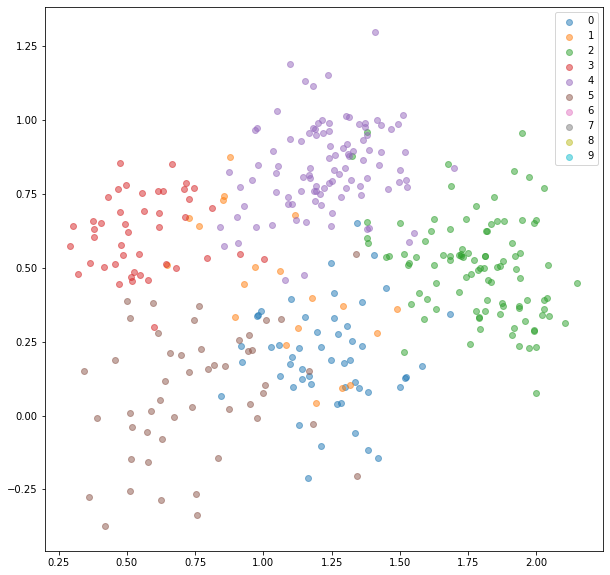

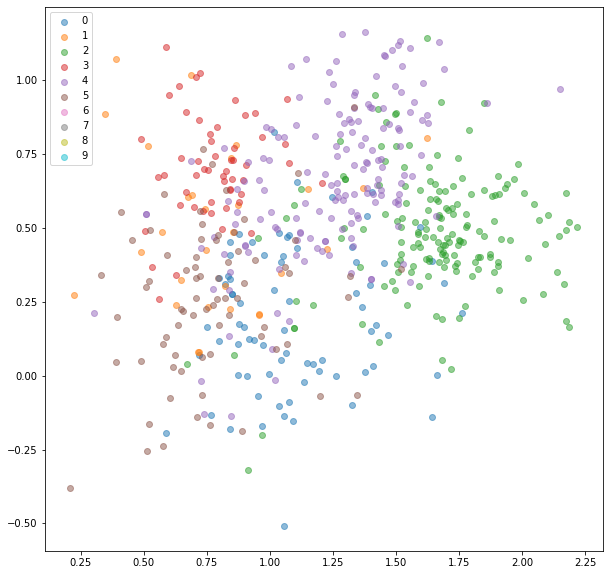

In [10]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)

val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

In [12]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(dset_train) # Returns triplets of images
triplet_test_dataset = TripletMNIST(dset_test)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 100
log_interval = 100

fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/366 (0%)]	Loss: 3.337567
Epoch: 1/100. Train set: Average loss: 1.9881
Epoch: 1/100. Validation set: Average loss: 1.3146
Train: [0/366 (0%)]	Loss: 0.976784
Epoch: 2/100. Train set: Average loss: 1.0325
Epoch: 2/100. Validation set: Average loss: 1.0594
Train: [0/366 (0%)]	Loss: 0.751551
Epoch: 3/100. Train set: Average loss: 0.7759
Epoch: 3/100. Validation set: Average loss: 0.8235
Train: [0/366 (0%)]	Loss: 0.688620
Epoch: 4/100. Train set: Average loss: 0.6630
Epoch: 4/100. Validation set: Average loss: 0.7640
Train: [0/366 (0%)]	Loss: 0.729920
Epoch: 5/100. Train set: Average loss: 0.6617
Epoch: 5/100. Validation set: Average loss: 0.8301
Train: [0/366 (0%)]	Loss: 0.516638
Epoch: 6/100. Train set: Average loss: 0.5326
Epoch: 6/100. Validation set: Average loss: 0.7965
Train: [0/366 (0%)]	Loss: 0.368423
Epoch: 7/100. Train set: Average loss: 0.4391
Epoch: 7/100. Validation set: Average loss: 0.7864
Train: [0/366 (0%)]	Loss: 0.508734
Epoch: 8/100. Train set: Average loss: 0.

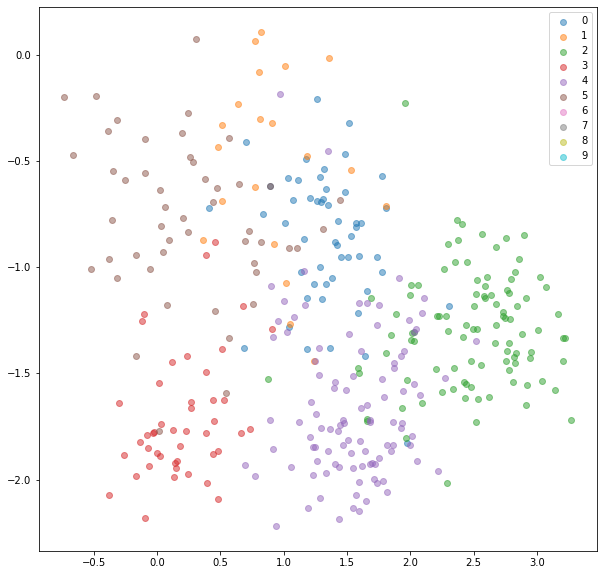

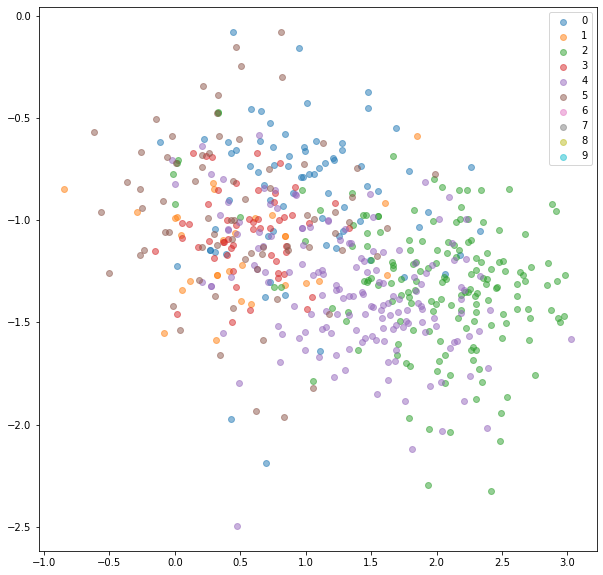

In [13]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **PairSelector** that takes embeddings and original labels and returns valid pairs within a minibatch
5. Define **OnlineContrastiveLoss** that will use a *PairSelector* and compute *ContrastiveLoss* on such pairs
6. Train the network!

In [6]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(dset_train.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(dset_test.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(dset_train, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(dset_test, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils.utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [7]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

/Users/alessandroromualdi/code/venv/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


ValueError: Cannot take a larger sample than population when 'replace=False'

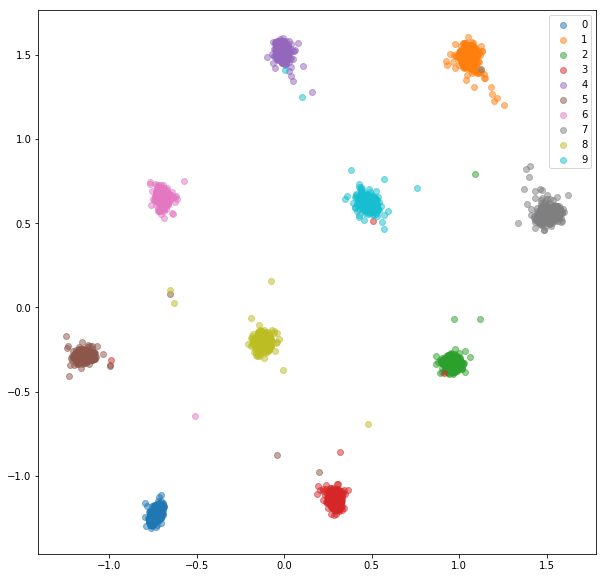

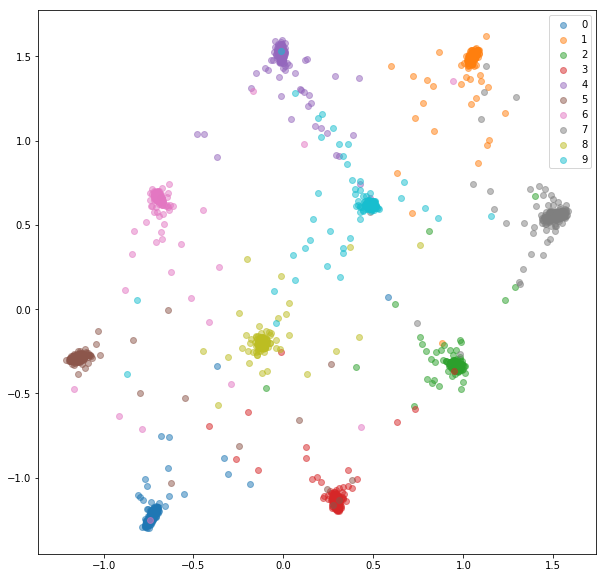

In [15]:
train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

## Online triplet selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
6. Train the network!

In [16]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [17]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

Train: [0/60000 (0%)]	Loss: 0.999806	Average nonzero triplets: 3000.0
Train: [12500/60000 (21%)]	Loss: 0.989613	Average nonzero triplets: 2648.725490196078
Train: [25000/60000 (42%)]	Loss: 0.994085	Average nonzero triplets: 2328.5346534653463
Train: [37500/60000 (62%)]	Loss: 0.958655	Average nonzero triplets: 2115.5165562913908
Train: [50000/60000 (83%)]	Loss: 0.976330	Average nonzero triplets: 1921.4925373134329
Epoch: 1/20. Train set: Average loss: 0.9805	Average nonzero triplets: 1801.7071129707113
Epoch: 1/20. Validation set: Average loss: 0.8326	Average nonzero triplets: 1218.6410256410256
Train: [0/60000 (0%)]	Loss: 0.876484	Average nonzero triplets: 1217.0
Train: [12500/60000 (21%)]	Loss: 0.991039	Average nonzero triplets: 975.3529411764706
Train: [25000/60000 (42%)]	Loss: 0.992353	Average nonzero triplets: 934.009900990099
Train: [37500/60000 (62%)]	Loss: 1.075175	Average nonzero triplets: 917.0596026490066
Train: [50000/60000 (83%)]	Loss: 1.023091	Average nonzero triplets: 889

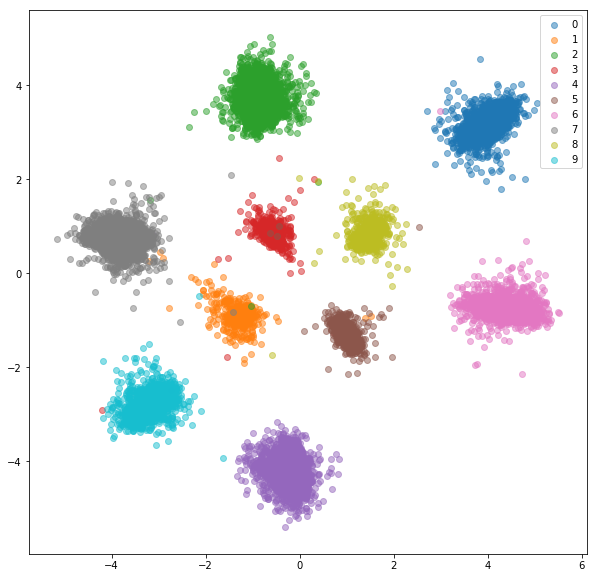

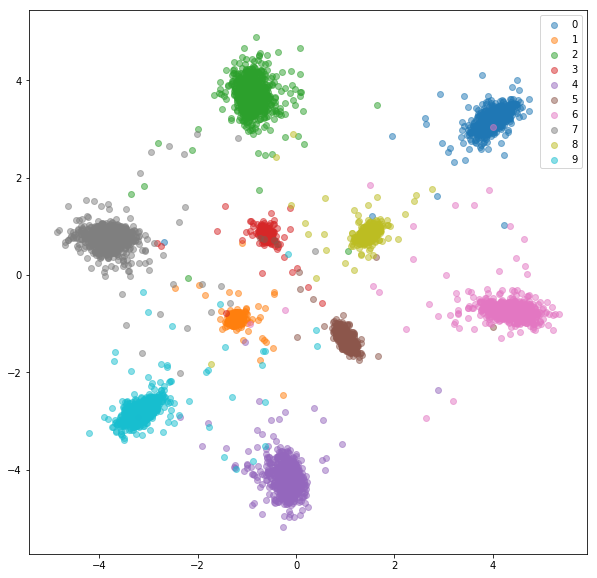

In [18]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

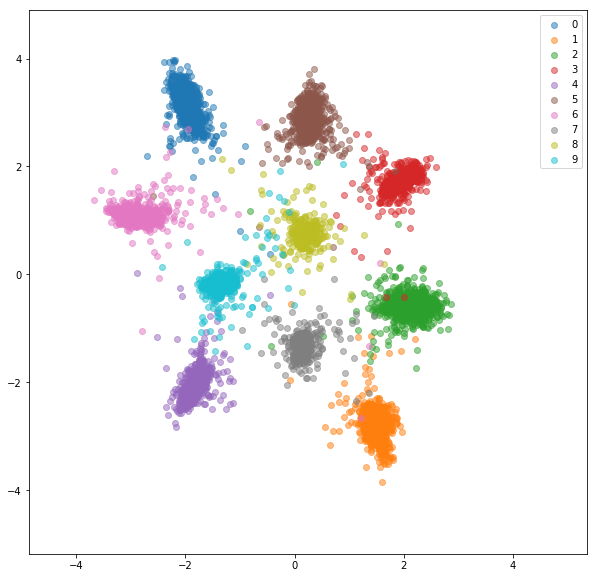

In [19]:
# display_emb_online, display_emb, display_label_online, display_label = train_embeddings_otl, train_embeddings_tl, train_labels_otl, train_labels_tl
display_emb_online, display_emb, display_label_online, display_label = val_embeddings_otl, val_embeddings_tl, val_labels_otl, val_labels_tl
x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)

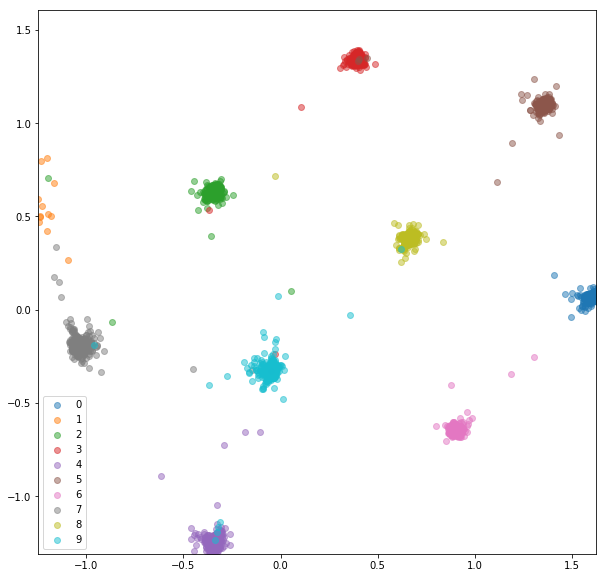

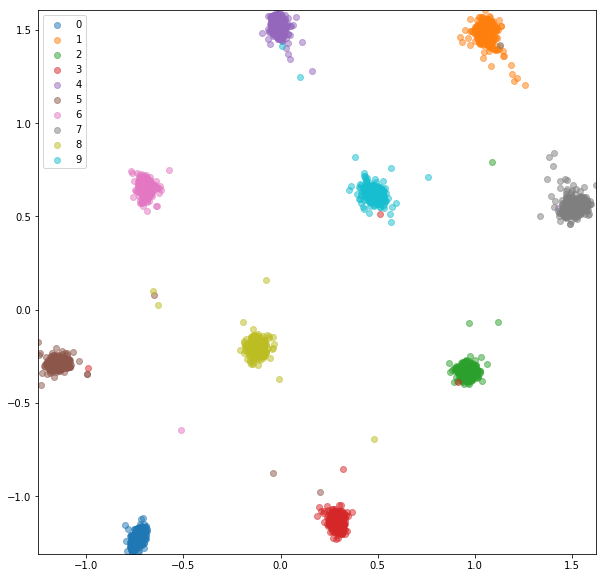

In [20]:
x_lim = (np.min(train_embeddings_ocl[:,0]), np.max(train_embeddings_ocl[:,0]))
y_lim = (np.min(train_embeddings_ocl[:,1]), np.max(train_embeddings_ocl[:,1]))
plot_embeddings(train_embeddings_cl, train_labels_cl, x_lim, y_lim)
plot_embeddings(train_embeddings_ocl, train_labels_ocl, x_lim, y_lim)